<a href="https://colab.research.google.com/github/raulsomazabracho/Clusterization/blob/main/Fraude_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing first libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Libraries

In [ ]:
#Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Data preparation
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Moachine learing models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#To Evaluate the models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

#To expor the chosen model
import pickle


### Uploading the Dataset

In [ ]:
#Upload the dataset
df = pd.read_csv('/content/drive/MyDrive/Data Science/Python/Clusterizaciones (Supervisadas)/Nala/DS Challenge_Nala.csv', sep = ';')

df.sample(5)

In [ ]:
#Dividing device column
device_cols = df['dispositivo'].str.split(';', n = 2).apply(pd.Series)

device_cols

In [ ]:
#Renaming columns
device_cols = device_cols.rename(columns = {0: 'device_model', 1: 'device_score', 2: 'device_os'})

device_cols

In [ ]:
#Incorporating the new created columns to the dataset
df = pd.concat([df, device_cols], axis = 1)

In [ ]:
#Inspecting the dataset
df.sample(5)

In [ ]:
#Dropping features that we wont be using
df.drop(columns = ['dispositivo', 'ID_USER'],inplace = True, index = 1)

In [ ]:
#Checking
df.head()

In [ ]:
#Cleaning our String columns
df['device_model'] = df['device_model'].map(lambda x: x.lstrip("{'model':"))
df['device_score'] = df['device_score'].map(lambda x: x.replace("'device_score':",""))
df['device_os'] = df['device_os'].map(lambda x: x.lstrip("'os': '").rstrip("'}"))

df['device_score'] = df['device_score'].astype(int)

In [ ]:
#Changing commas for dots
df['cashback'] = df['cashback'].map(lambda x: x.replace(",","."))
df['dcto'] = df['dcto'].map(lambda x: x.replace(",","."))
df['monto'] = df['monto'].map(lambda x: x.replace(",","."))

In [ ]:
#Changing variables types
df['cashback'] = df['cashback'].astype(float)
df['dcto'] = df['dcto'].astype(float)
df['monto'] = df['monto'].astype(float)

In [ ]:
#Replacing strange characters
df['tipo_tc'] = df['tipo_tc'].str.replace('FÃ­sica', 'Fisica')

In [ ]:
#Adjusting the date column
df['fecha'] = df['fecha'].astype('datetime64[ns]')
df['mes'] = pd.DatetimeIndex(df['fecha']).month
df['año'] = pd.DatetimeIndex(df['fecha']).year

In [ ]:
#Checking our date variables
print(df.mes.sort_values().unique())
print(df.año.sort_values().unique())

In [ ]:
#Checking all teh changes
df.sample(5)

In [ ]:
#checking null values
df.isnull().sum()

In [ ]:
#Revisamos nuestros tipos de variables
df.info()

### EDA

In [ ]:
#Checking our numeric variables
numeric_cols = df._get_numeric_data()

numeric_cols.head()

In [ ]:
#Describing our numeric variables
numeric_cols.describe()

In [ ]:
#Observating the correlations between our features
fig, ax = plt.subplots()
fig.set_size_inches(12,12)

sns.heatmap(numeric_cols.corr(), vmin=-1, vmax=1, annot=True, cmap = 'Blues_r')

It doesnt seem to be significant correlations in our variables, except between amount and cashback. This does not seem to indicate that they are variables of interest for our analysis and/or model, but rather an indication that the data in our dataset makes sense.

In [ ]:
#Observing the distribution of fraude transactions
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

plt.subplot(1,2,1)
status_txn_1 = sns.countplot(data = df, x = 'status_txn', hue = 'fraude')
plt.xlabel('State of Transaction')
plt.ylabel('Amount of transactions')

plt.subplot(1,2,2)
status_txn_2 = sns.countplot(data = df, x = 'status_txn', hue = 'fraude')
status_txn_2.set_yscale('log')
plt.xlabel('State of transaction')
plt.ylabel('Amount of transactions (logarithmic scale))')


plt.suptitle('Frauds per state of transaction', size = 20)
plt.show()

In [ ]:
#Observating if theres any relation between cashback and frauds
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

sns.scatterplot(data = df.sample(500), x = 'monto', y = 'cashback',hue = 'fraude', s = 50, alpha = 0.7)

We can see that there is a direct relationship between the amount and the cashback, but that the cashback is not the same for all customers, so we will create a new column called percent_cashback

In [ ]:
#Creating the new percent_cashback column
df['percent_cashback'] = (df['cashback']/df['monto'])*100
df['percent_cashback'] = df.percent_cashback.round(1)
df.head()

In [ ]:
#Checking different cashbak possibilities
df.percent_cashback.unique()

In [ ]:
#Creating a dataset containing only the frauds
fraudes = df[df['fraude'] == True]

In [ ]:
#Observating transaction distribution per cashback percentage
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

plt.subplot(1,2,1)
count_cashback = sns.countplot(data = df, x = 'percent_cashback', hue = 'fraude')
plt.xlabel('Cashback Percentage')
plt.ylabel('Amount of transactions')

plt.subplot(1,2,2)
count_cashback = sns.countplot(data = df, x = 'percent_cashback', hue = 'fraude')
plt.xlabel('Cashback Percentage')
plt.ylabel('Amount of transactions (logarithmic scale)')
count_cashback.set_yscale('log')

plt.show()

The cashback percentage does not seem to have a significant influence, the number of frauds tends to be proportional to the number of cashback transactions.

In [ ]:
#Same analysis with discounts
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

#df
plt.subplot(1,2,1)
sns.scatterplot(data = df.sample(100), x = 'monto', y = 'dcto', hue = 'fraude',s = 75, alpha = 0.5)

#fraudes
plt.subplot(1,2,2)
sns.scatterplot(data = fraudes.sample(100), x = 'monto', y = 'dcto',s = 75, alpha = 0.5)

We see a similar pattern to the cashback charts, so we'll create the same percentage column for amount.

In [ ]:
#Creating the column
df['percent_disc'] = (df['dcto']/df['monto'])*100
df['percent_disc'] = df.percent_disc.round(1)

df.head()

In [ ]:
#Observating patterns in our categorical features
df_1 = df.select_dtypes(['object','boolean'])

for i, col in enumerate(df_1):
    plt.figure(i)
    chart = sns.countplot(x = col, data = df_1, hue = 'fraude')
    chart.set_yscale('log')

In [ ]:
#Zooming the frauds
fraud_cols = fraudes.select_dtypes(['object','boolean'])

for i, col in enumerate(df_1):
    plt.figure(i)
    sns.countplot(x = col, data = fraud_cols)

In [ ]:
#We look at how regular and fraudulent transactions are distributed by amount
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax.hist(df.monto, alpha = 0.5)
ax.hist(fraudes.monto, alpha = 0.8, label = 'Fraudes')
ax.legend()
ax.set_yscale('log')
fig.suptitle('Regular and fraud transaction por sum')

plt.show()

In [ ]:
#Sme for TC line
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax.hist(df.linea_tc, alpha = 0.5)
ax.hist(fraudes.linea_tc, alpha = 0.8, label = 'Fraudes')
ax.legend()
ax.set_yscale('log')
fig.suptitle('Regular and fraud transaction per TC Line')

plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax.hist(df.interes_tc, alpha = 0.5)
ax.hist(fraudes.interes_tc, alpha = 0.8, label = 'Fraudes')
ax.legend()
ax.set_yscale('log')
fig.suptitle('Regular and fraud transaction per TC Line (Logarithmic scale')

plt.show()

There do not seem to be significant variations in both graphs

## Dataset Preparation

In [ ]:
#Plotting missing values
sns.heatmap(df.isna().sort_values(by = ['establecimiento','ciudad']))

In [ ]:
#Percentage of missing values per column
null_totals = df.isnull().sum().sort_values(ascending = False)
percent_nulls = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_df = pd.concat([null_totals, percent_nulls], axis = 1, keys = ['total_nulls', 'percent_total'])

missing_df

In [ ]:
#Dropping useless columns with to many missing values
df.drop(columns = ['establecimiento','ciudad', 'device_model'], axis= 1, inplace = True)

In [ ]:
#Checking
df.head()

In [ ]:
df.drop(columns = ['percent_cashback','percent_disc'], axis= 1, inplace = True)

In [ ]:
print(df.groupby('fraude').size())

In [ ]:
#Encoding target variable
encoder = OneHotEncoder(sparse = False)

result = encoder.fit_transform(df[['fraude']])
fraud_ = pd.DataFrame(result, columns = list(encoder.categories_[0]))

print(fraud_.value_counts())

df_ml = pd.concat([df, fraud_], axis = 1)

In [ ]:
#Drpping fraude column
df_ml.drop(['fraude', False], axis = 1, inplace = True)

In [ ]:
#Dropping rows with null values
df_ml.dropna(how = 'any', inplace = True)

In [ ]:
#Renaming target variable
df_ml = df_ml.rename({True:'is_True'}, axis = 1)

df_ml.head()

# standardization

## Numeric Features

In [ ]:
numeric_df = df_ml[['monto', 'hora', 'linea_tc','interes_tc','dcto','cashback','device_score', 'mes']]
print(numeric_df.head())

        monto  hora  linea_tc  ...   cashback  device_score  mes
0  608.345633  20.0   71000.0  ...   5.475111           3.0  1.0
2  790.037653  11.0   94000.0  ...  15.800753           1.0  1.0
3  767.005387  11.0   94000.0  ...   7.670054           3.0  5.0
4  254.171053  10.0   94000.0  ...   2.541711           3.0  1.0
5   37.003747   3.0   94000.0  ...   0.370037           2.0  1.0

[5 rows x 8 columns]


In [ ]:
normalized_df = numeric_df
for i in enumerate(numeric_df.columns): 
  normalized_df[i[1]] = (numeric_df[i[1]] - numeric_df [i[1]].mean()) / numeric_df [i[1]].std()

normalized_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,monto,hora,linea_tc,interes_tc,dcto,cashback,device_score,mes
0,0.377663,1.206235,0.389390,0.289494,1.263040,-0.176355,-0.001831,-0.647985
2,1.005683,-0.148663,1.440232,0.811007,-0.508728,2.139581,-1.412885,-0.647985
3,0.926072,-0.148663,1.440232,0.811007,-0.508728,0.315948,-0.001831,0.493423
4,-0.846543,-0.299208,1.440232,0.811007,-0.508728,-0.834287,-0.001831,-0.647985
5,-1.597184,-1.353018,1.440232,0.811007,-0.508728,-1.321371,-0.707358,-0.647985


## Categorical Features

In [ ]:
categorical_df_columns = df_ml[['tipo_tc', 'status_txn','is_prime','device_os']]
categorical_df = pd.get_dummies(categorical_df_columns, columns=['tipo_tc', 'status_txn','is_prime','device_os'], drop_first=True)
print(categorical_df.head())

   tipo_tc_Virtual  status_txn_En proceso  ...  device_os_ANDROID  device_os_WEB
0                0                      0  ...                  1              0
2                1                      1  ...                  0              0
3                0                      0  ...                  0              1
4                0                      0  ...                  0              0
5                0                      0  ...                  0              0

[5 rows x 7 columns]


## Joining both

In [ ]:
df_norm = pd.concat([normalized_df,categorical_df], axis =1)
df_norm.head()

,monto,hora,linea_tc,interes_tc,dcto,cashback,device_score,mes,tipo_tc_Virtual,status_txn_En proceso,status_txn_Rechazada,is_prime_True,"device_os_,",device_os_ANDROID,device_os_WEB
0,0.377663,1.206235,0.389390,0.289494,1.263040,-0.176355,-0.001831,-0.647985,0,0,0,0,0,1,0
2,1.005683,-0.148663,1.440232,0.811007,-0.508728,2.139581,-1.412885,-0.647985,1,1,0,0,1,0,0
3,0.926072,-0.148663,1.440232,0.811007,-0.508728,0.315948,-0.001831,0.493423,0,0,0,0,0,0,1
4,-0.846543,-0.299208,1.440232,0.811007,-0.508728,-0.834287,-0.001831,-0.647985,0,0,0,0,0,0,0
5,-1.597184,-1.353018,1.440232,0.811007,-0.508728,-1.321371,-0.707358,-0.647985,0,0,1,0,0,0,0


# Train_Test_Split

In [ ]:
#Separate target  from features
x = df_norm
y = df_ml[['is_True']]

In [ ]:
y.value_counts()

is_True
0.0        26163
1.0          810
dtype: int64

In [ ]:
#Train_Test_Split

print("Size of the data", len(x))
print("Target Variable values: \n ", y.value_counts())

df_ml_dmatrix = xgb.DMatrix(data = x, label = y)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 48)

#Observate the difference in the sampling when using smote
print('Before OverSampling, the shape of train_X: {}'.format(x_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))
print("Counts of labels '\n",y_train.value_counts())

x.head()

Size of the data 26973
Target Variable values: 
  is_True
0.0        26163
1.0          810
dtype: int64
Before OverSampling, the shape of train_X: (20229, 15)
Before OverSampling, the shape of train_y: (20229, 1) 

Counts of labels '
 is_True
0.0        19621
1.0          608
dtype: int64


,monto,hora,linea_tc,interes_tc,dcto,cashback,device_score,mes,tipo_tc_Virtual,status_txn_En proceso,status_txn_Rechazada,is_prime_True,"device_os_,",device_os_ANDROID,device_os_WEB
0,0.377663,1.206235,0.389390,0.289494,1.263040,-0.176355,-0.001831,-0.647985,0,0,0,0,0,1,0
2,1.005683,-0.148663,1.440232,0.811007,-0.508728,2.139581,-1.412885,-0.647985,1,1,0,0,1,0,0
3,0.926072,-0.148663,1.440232,0.811007,-0.508728,0.315948,-0.001831,0.493423,0,0,0,0,0,0,1
4,-0.846543,-0.299208,1.440232,0.811007,-0.508728,-0.834287,-0.001831,-0.647985,0,0,0,0,0,0,0
5,-1.597184,-1.353018,1.440232,0.811007,-0.508728,-1.321371,-0.707358,-0.647985,0,0,1,0,0,0,0


# Machine Learning without SMOTE

## Logistic Regression

In [ ]:
#HACEMOS REGRESION LOGISTICA
lr_sampled = LogisticRegression()
lr_sampled.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

#### Evaluating the model

In [ ]:
#imprimimos matriz de confusion de la regresion
from sklearn.metrics import confusion_matrix
#predecimos 
y_predic = lr_sampled.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido Fraude'], index = ['Verdaderamente normal', 'verdaderamente Fraude'])

,Predecido Normal,Predecido Fraude
Verdaderamente normal,6542,0
verdaderamente Fraude,202,0


##### ROC/AUC

In [ ]:
#Evaluamos el performance
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test,y_predic)
print(auc_roc)

0.5


In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

Text(0.5, 0, 'False Positive Rate')

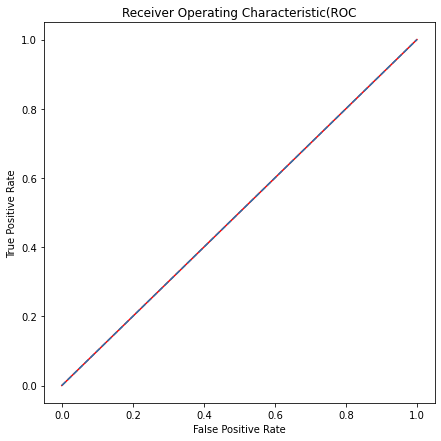

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize =(7,7))
plt.title("Receiver Operating Characteristic(ROC")
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

##### PRC

In [ ]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      6542
         1.0       0.00      0.00      0.00       202

    accuracy                           0.97      6744
   macro avg       0.49      0.50      0.49      6744
weighted avg       0.94      0.97      0.96      6744



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistica: f1=0.000 auc=0.515
[0.02995255 1.        ]
[1. 0.]


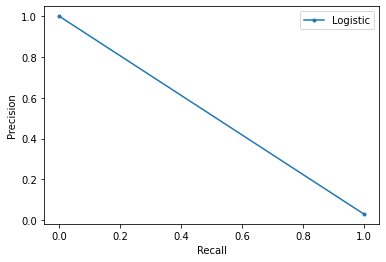

In [ ]:
#importamos las librerias
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

#sacamos las metricas
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_predic)
lr_f1, lr_auc = f1_score(y_test, y_predic), auc(lr_recall, lr_precision)
# sumamos los scores e imprimimos
print('Logistica: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print(lr_precision)
print(lr_recall)
# graficamos el prc
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

### Logistic Regression with hyperparameteres

In [ ]:
#Importamos el grid_search y configuramos los parametros
from sklearn.model_selection import GridSearchCV

LR_model = LogisticRegression()

parametros = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,
              'penalty':['l1','l2']}

lr_grid = GridSearchCV(LR_model,parametros,cv = 4)


In [ ]:
#entrenamos el modelo
lr_grid.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=4, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

#### Evaluating the model

In [ ]:
#imprimimos matriz de confusion de la regresion
from sklearn.metrics import confusion_matrix
#predecimos 
y_predic = lr_grid.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido Fraude'], index = ['Verdaderamente normal', 'verdaderamente Fraude'])

,Predecido Normal,Predecido Fraude
Verdaderamente normal,6542,0
verdaderamente Fraude,202,0


##### ROC/AUC

In [ ]:
#Evaluamos el performance
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test,y_predic)
print(auc_roc)

0.5


In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

Text(0.5, 0, 'False Positive Rate')

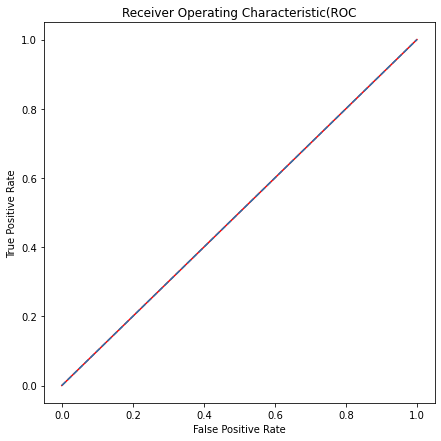

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize =(7,7))
plt.title("Receiver Operating Characteristic(ROC")
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

##### PRC

In [ ]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      6542
         1.0       0.00      0.00      0.00       202

    accuracy                           0.97      6744
   macro avg       0.49      0.50      0.49      6744
weighted avg       0.94      0.97      0.96      6744



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Desicion Tree

In [ ]:
#Importamos el modelo
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 12)

In [ ]:
#Entrenamos
dt.fit(x_train,y_train)

DecisionTreeClassifier(random_state=12)

#### Evaluating the model

In [ ]:
#imprimimos matriz de confusion de la regresion
from sklearn.metrics import confusion_matrix
#predecimos 
y_predic = dt.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido Fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido Fraude
Verdaderamente normal,6275,267
verdaderamente fraude,193,9


##### ROC/AUC

In [ ]:
#Evaluamos el performance
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test,y_predic)
print(auc_roc)

0.5018706242375994


In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5018706242375994

Text(0.5, 0, 'False Positive Rate')

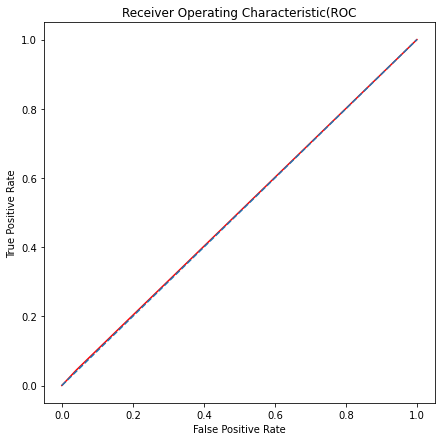

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize =(7,7))
plt.title("Receiver Operating Characteristic(ROC")
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

##### PRC

In [ ]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      6542
         1.0       0.03      0.04      0.04       202

    accuracy                           0.93      6744
   macro avg       0.50      0.50      0.50      6744
weighted avg       0.94      0.93      0.94      6744



Logistica: f1=0.038 auc=0.053
[0.02995255 0.0326087  1.        ]
[1.         0.04455446 0.        ]


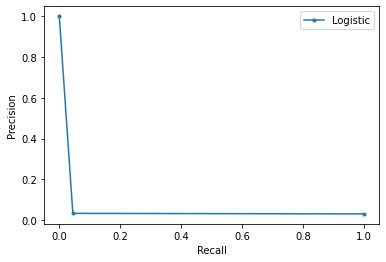

In [ ]:
#importamos las librerias
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

#sacamos las metricas
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_predic)
lr_f1, lr_auc = f1_score(y_test, y_predic), auc(lr_recall, lr_precision)
# sumamos los scores e imprimimos
print('Logistica: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print(lr_precision)
print(lr_recall)
# graficamos el prc
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

### Random Forest

In [ ]:
#Importamos el modelo
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 38, criterion = 'gini', random_state = 45)

In [ ]:
from sklearn.metrics import confusion_matrix

#entrenamos
rf.fit(x_train,y_train)

#predecimos

y_predic= rf.predict(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


#### Evaluating the model

In [ ]:
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido fraude
Verdaderamente normal,6542,0
verdaderamente fraude,202,0


##### ROC/AUC

In [ ]:
#Evaluamos el performance
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test,y_predic)
print(auc_roc)

0.5


In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

Text(0.5, 0, 'False Positive Rate')

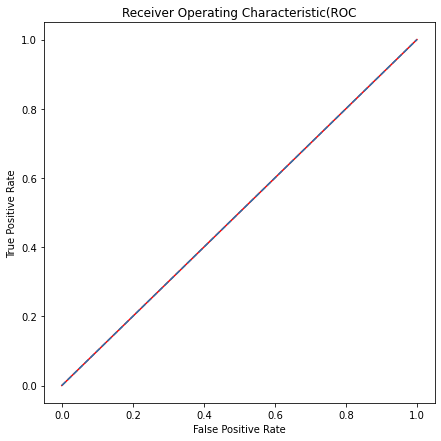

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize =(7,7))
plt.title("Receiver Operating Characteristic(ROC")
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

##### PRC

In [ ]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      6542
         1.0       0.00      0.00      0.00       202

    accuracy                           0.97      6744
   macro avg       0.49      0.50      0.49      6744
weighted avg       0.94      0.97      0.96      6744



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistica: f1=0.000 auc=0.515
[0.02995255 1.        ]
[1. 0.]


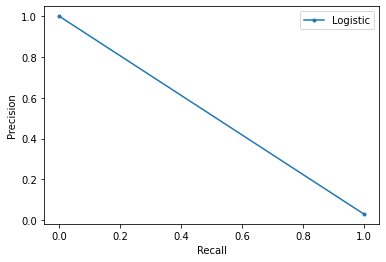

In [ ]:
#importamos las librerias
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

#sacamos las metricas
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_predic)
lr_f1, lr_auc = f1_score(y_test, y_predic), auc(lr_recall, lr_precision)
# sumamos los scores e imprimimos
print('Logistica: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print(lr_precision)
print(lr_recall)
# graficamos el prc
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

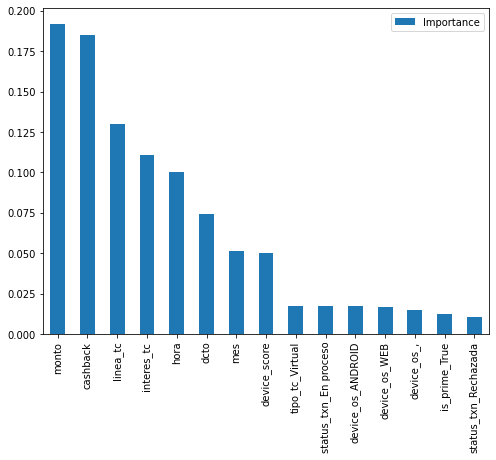

In [ ]:
feat_importances = pd.DataFrame(rf.feature_importances_, x.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Random Forest with Hyperparameters

#### Setting the hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#### Creating the model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

### Evaluating the model

In [ ]:
best_random = rf_random.best_estimator_
print(best_random)

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=400)


In [ ]:
#imprimimos matriz de confusion de la regresion
from sklearn.metrics import confusion_matrix
#predecimos 
y_predic = dt.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido fraude
Verdaderamente normal,6275,267
verdaderamente fraude,193,9


##### ROC/AUC

In [ ]:
#Evaluamos el performance
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test,y_predic)
print(auc_roc)

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

##### PRC

In [ ]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

In [ ]:
#importamos las librerias
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

#sacamos las metricas
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_predic)
lr_f1, lr_auc = f1_score(y_test, y_predic), auc(lr_recall, lr_precision)
# sumamos los scores e imprimimos
print('Logistica: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print(lr_precision)
print(lr_recall)
# graficamos el prc
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
#Observamos nuestro dataset de features

df_ml_dmatrix = xgb.DMatrix(data = x, label = y)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 42)

x.head()

In [ ]:
#Entrenamos los modelos a utilizar: Logistic Regression, Random Forest y XGBoost

lr = LogisticRegression()
lr.fit(x_train, y_train.values.ravel())
predict_lr = lr.predict(x_test)
print('Logistic Regression Score: ',lr.score(x_test, y_test))
lr_coef = lr.coef_[0]

random_forest = RandomForestClassifier(n_estimators = 200, max_features= 0.4, max_depth= 10, criterion = 'entropy', random_state= 0)
random_forest.fit(x_train, y_train.values.ravel())
predict_rf = random_forest.predict(x_test)
print('Random Forest Score: ', random_forest.score(x_test, y_test))

xg = xgb.XGBClassifier(n_estimators= 200,max_depth = 5, seed = 0, eval_metric = ['error', 'logloss'], use_label_encoder= False)
xg.fit(x_train, y_train.values.ravel())
predict_xg = xg.predict(x_test)
print('XGBoost Score: ', xg.score(x_test, y_test))

Podemos ver que el accuracy es demasiado alto, lo que indica un overfit del modelo. Realizaremos una validación cruzada para comprobar esto

In [ ]:
from sklearn.model_selection import cross_val_score

cv_lr = cross_val_score(lr, x_train, y_train.values.ravel(), cv = 10)
cv_rf = cross_val_score(random_forest, x_train, y_train.values.ravel(), cv = 10)
cv_xg = cross_val_score(xg, x_train, y_train.values.ravel(), cv = 10)

print('LR Cross Validation Scores: ',cv_lr)
print('Random Forest Cross Validation Scores: ',cv_rf)
print('Random Forest Cross Validation Scores: ',cv_xg)

Ahora armaremos la matriz de confusión para cada modelo

In [ ]:
prediction_lr = lr.predict(x_test)

prediction_rf = random_forest.predict(x_test)

prediction_xg = xg.predict(x_test)

In [ ]:
#Regresión Logística
pd.DataFrame(confusion_matrix(y_test, predict_lr), columns = ['Predicted No', 'Predicted Yes'], index = ['Actual No', 'Actual Yes'])

In [ ]:
#Random Forest
pd.DataFrame(confusion_matrix(y_test, predict_rf), columns = ['Predicted No', 'Predicted Yes'], index = ['Actual No', 'Actual Yes'])

In [ ]:
#Xgboost
pd.DataFrame(confusion_matrix(y_test, predict_xg), columns = ['Predicted No', 'Predicted Yes'], index = ['Actual No', 'Actual Yes'])

In [ ]:
#Evaluamos nuestro modelo
import warnings
warnings.filterwarnings('ignore')

print(classification_report(y_test,predict_lr))

In [ ]:
print(classification_report(y_test,prediction_rf))

In [ ]:
#Vemos las variables con mayor incidencia en el modelo de Regresión Logística, que será el que pondremos en producción
incidencia_lr = pd.DataFrame(lr_coef, 
                     x.columns, 
                     columns=['coef'])\
                    .sort_values(by='coef', ascending=False)

print (incidencia_lr.sort_values(by = 'coef'))

In [ ]:
#Guardamos el modelo
filename = 'logistic_regression_model.pkl'
pickle.dump(lr, open(filename, 'wb'))

In [ ]:
#Comprobamos que se puede cargar y abrir correctamente
loaded_model = pickle.load(open('logistic_regression_model.pkl','rb'))
result = loaded_model.score(x_test, y_test)

result

# Machine Learning with SMOTE

In [ ]:
#Observate the difference in the sampling when using smote
print('Before OverSampling, the shape of train_X: {}'.format(x_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("Before OverSampling, counts of labels '\n",y_train.value_counts())

sm = SMOTE(random_state = 2)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
  
print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("Before OverSampling, counts of labels \n",y_train_res.value_counts())


Before OverSampling, the shape of train_X: (20229, 15)
Before OverSampling, the shape of train_y: (20229, 1) 

Before OverSampling, counts of labels '
 is_True
0.0        19621
1.0          608
dtype: int64
After OverSampling, the shape of train_X: (39242, 15)
After OverSampling, the shape of train_y: (39242, 1) 

Before OverSampling, counts of labels 
 is_True
1.0        19621
0.0        19621
dtype: int64


### Random Forest

In [ ]:
#Importing the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 25, criterion = 'gini', random_state = 45)

In [ ]:
from sklearn.metrics import confusion_matrix

#Training the model
rf.fit(x_train_res,y_train_res)

#Predicting with the model

y_predic= rf.predict(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


#### Evaluating the model

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
#Evaluating
y_predic = rf.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido Fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido Fraude
Verdaderamente normal,6428,114
verdaderamente fraude,198,4


## Random Forest with hyperparameters

### Creating the model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(x_train_res, y_train_res)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100]},
                   random_state=42, verbose=2)

### Evaluating the model

In [ ]:
best_random = rf_random.best_estimator_
print(best_random)

RandomForestClassifier(bootstrap=False, n_estimators=10)


In [ ]:
y_predic = rf_random.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido Fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido Fraude
Verdaderamente normal,6464,78
verdaderamente fraude,201,1


# Machine Learning with NearMiss

In [ ]:
# apply near miss
from imblearn.under_sampling import NearMiss

#Observate the difference in the sampling when using smote
print('Before OverSampling, the shape of train_X: {}'.format(x_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))
print("Before OverSampling, counts of labels '\n",y_train.value_counts())

nr = NearMiss()
x_train_miss, y_train_miss = nr.fit_resample(x_train, y_train)

print('After Resampling, the shape of train_X: {}'.format(x_train_miss.shape))
print('After Resampling, the shape of train_y: {} \n'.format(y_train_miss.shape))
print("After Resampling, counts of labels \n",y_train_miss.value_counts())

Before OverSampling, the shape of train_X: (20229, 15)
Before OverSampling, the shape of train_y: (20229, 1) 

Before OverSampling, counts of labels '
 is_True
0.0        19621
1.0          608
dtype: int64
After Resampling, the shape of train_X: (1216, 15)
After Resampling, the shape of train_y: (1216, 1) 

After Resampling, counts of labels 
 is_True
1.0        608
0.0        608
dtype: int64


## Random Forest

### Creating the model

In [ ]:
#Importing the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 12, criterion = 'gini', random_state = 45)

In [ ]:
#Training the model
rf.fit(x_train_miss,y_train_miss)

#Predicting
y_predic= rf.predict(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
#Predicting with the model
y_predic= rf.predict(x_test)

### Evaluating the model

In [ ]:
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido fraude
Verdaderamente normal,1290,5252
verdaderamente fraude,40,162


In [ ]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.97      0.18      0.31      6542
         1.0       0.03      0.81      0.06       202

    accuracy                           0.20      6744
   macro avg       0.50      0.50      0.18      6744
weighted avg       0.94      0.20      0.30      6744



## Random Forest With Hyperparameters

### Creating the model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(x_train_miss, y_train_miss)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

### Evaluating the model

In [ ]:
best_random = rf_random.best_estimator_
print(best_random)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200)


In [ ]:
y_predic = rf_random.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido Fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido Fraude
Verdaderamente normal,1295,5247
verdaderamente fraude,39,163


In [ ]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.97      0.20      0.33      6542
         1.0       0.03      0.81      0.06       202

    accuracy                           0.22      6744
   macro avg       0.50      0.50      0.19      6744
weighted avg       0.94      0.22      0.32      6744



# Machine Learning with SMOTE + ENN

In [ ]:
# apply near miss
from imblearn.combine import SMOTEENN

#Observate the difference in the sampling when using smote
print('Before OverSampling, the shape of train_X: {}'.format(x_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))
print("Before OverSampling, counts of labels '\n",y_train.value_counts())

smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

print('After Resampling, the shape of train_X: {}'.format(x_train_smenn.shape))
print('After Resampling, the shape of train_y: {} \n'.format(y_train_smenn.shape))
print("After Resampling, counts of labels \n",y_train_smenn.value_counts())

Before OverSampling, the shape of train_X: (20229, 15)
Before OverSampling, the shape of train_y: (20229, 1) 

Before OverSampling, counts of labels '
 is_True
0.0        19621
1.0          608
dtype: int64
After Resampling, the shape of train_X: (34943, 15)
After Resampling, the shape of train_y: (34943, 1) 

After Resampling, counts of labels 
 is_True
1.0        19518
0.0        15425
dtype: int64


## Random Forest

### Creating the model

In [ ]:
#Importing the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 13, criterion = 'gini', random_state = 45)

In [ ]:
#Training the model
rf.fit(x_train_smenn,y_train_smenn)

#Predicting
y_predic= rf.predict(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### Evaluating the model

In [ ]:
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido fraude
Verdaderamente normal,6254,288
verdaderamente fraude,192,10


In [ ]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      6542
         1.0       0.03      0.05      0.04       202

    accuracy                           0.93      6744
   macro avg       0.50      0.50      0.50      6744
weighted avg       0.94      0.93      0.94      6744



Por cuestiones de tiempo, no se siguieron realizando pruebas para incrementar la efectividad del modelo, sin embargo, uno de los métodos que se utilizó fue el de normalización.

Puede verse el código utilizado en la sección de Apéndice.

## Apéndice

Para mejorar la efectividad del modelo, se procedió a crear un nuevo dataset con data normalizada. 

De igual manera, el algoritmo siguió memorizando el dataset y se obtuvieron los mismos resultados.


In [ ]:
normalized_df = df[['monto', 'hora', 'percent_disc', 'percent_cashback', 'device_score', 'linea_tc', 'mes']]

In [ ]:

norm = '_norm'
for i in enumerate(normalized_df.columns): 
  normalized_df[i[1]+norm] = (normalized_df[i[1]] - normalized_df[i[1]].mean()) / normalized_df[i[1]].std()

normalized_df.head()

,monto,hora,percent_disc,percent_cashback,device_score,linea_tc,mes,monto_norm,hora_norm,percent_disc_norm,percent_cashback_norm,device_score_norm,linea_tc_norm,mes_norm
0,608.345633,20,10.0,0.9,3,71000,1,0.377668,1.206180,1.133566,-0.788129,-0.001883,0.389428,-0.647994
2,790.037653,11,0.0,2.0,1,94000,1,1.005699,-0.148707,-0.615579,1.665199,-1.412912,1.440269,-0.647994
3,767.005387,11,0.0,1.0,3,94000,5,0.926087,-0.148707,-0.615579,-0.565099,-0.001883,1.440269,0.493435
4,254.171053,10,0.0,1.0,3,94000,1,-0.846561,-0.299250,-0.615579,-0.565099,-0.001883,1.440269,-0.647994
5,37.003747,3,0.0,1.0,2,94000,1,-1.597215,-1.353051,-0.615579,-0.565099,-0.707397,1.440269,-0.647994


In [ ]:
normalized_df.drop(columns = 'linea_tc', axis = 1, inplace = True)

normalized_df.head()

,monto,hora,percent_disc,percent_cashback,device_score,mes,monto_norm,hora_norm,percent_disc_norm,percent_cashback_norm,device_score_norm,linea_tc_norm,mes_norm
0,608.345633,20,10.0,0.9,3,1,0.377668,1.206180,1.133566,-0.788129,-0.001883,0.389428,-0.647994
2,790.037653,11,0.0,2.0,1,1,1.005699,-0.148707,-0.615579,1.665199,-1.412912,1.440269,-0.647994
3,767.005387,11,0.0,1.0,3,5,0.926087,-0.148707,-0.615579,-0.565099,-0.001883,1.440269,0.493435
4,254.171053,10,0.0,1.0,3,1,-0.846561,-0.299250,-0.615579,-0.565099,-0.001883,1.440269,-0.647994
5,37.003747,3,0.0,1.0,2,1,-1.597215,-1.353051,-0.615579,-0.565099,-0.707397,1.440269,-0.647994


In [ ]:
normalized_df = pd.merge(normalized_df, df[['fraude']], left_index= True, right_index = True)

normalized_df

,monto,hora,percent_disc,percent_cashback,device_score,mes,monto_norm,hora_norm,percent_disc_norm,percent_cashback_norm,device_score_norm,linea_tc_norm,mes_norm,fraude
0,608.345633,20,10.0,0.9,3,1,0.377668,1.206180,1.133566,-0.788129,-0.001883,0.389428,-0.647994,False
2,790.037653,11,0.0,2.0,1,1,1.005699,-0.148707,-0.615579,1.665199,-1.412912,1.440269,-0.647994,False
3,767.005387,11,0.0,1.0,3,5,0.926087,-0.148707,-0.615579,-0.565099,-0.001883,1.440269,0.493435,False
4,254.171053,10,0.0,1.0,3,1,-0.846561,-0.299250,-0.615579,-0.565099,-0.001883,1.440269,-0.647994,False
5,37.003747,3,0.0,1.0,2,1,-1.597215,-1.353051,-0.615579,-0.565099,-0.707397,1.440269,-0.647994,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26970,746.192089,13,0.0,1.0,2,8,0.854144,0.152379,-0.615579,-0.565099,-0.707397,-1.026922,1.349507,False
26971,941.804966,15,0.0,1.0,2,1,1.530294,0.453465,-0.615579,-0.565099,-0.707397,-1.026922,-0.647994,False
26972,251.189885,11,0.0,2.0,2,1,-0.856866,-0.148707,-0.615579,1.665199,-0.707397,-1.026922,-0.647994,False
26973,24.182665,17,10.0,0.9,5,1,-1.641532,0.754551,1.133566,-0.788129,1.409145,-1.026922,-0.647994,False
